# Congestion control algorithm

## Run experiments

In [7]:
import sem
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

# Create our SEM campaign
ns_3_dir = '../../../../'
script = 'congestion-example'
results_dir = 'congestion-results'
campaign = sem.CampaignManager.new(ns_3_dir, script, results_dir,
                                   check_repo=False, overwrite=False)

# Define the parameter space we are interested in exploring
params = {
    "devices": 2000,
    "rings": 1,
    "periods": 24 * 7,
    "initSF": True,
    "congest": True,
    "file": True,
    "sir": "CROCE",
}
runs = 10

In [ ]:
# Run simulations with the above parameter space
campaign.run_missing_simulations(params, runs)

## Global PDR over time

In [49]:
@sem.utils.output_labels(['Hours', 'PDR'])
def get_global_pdr (result):
    """
    Extract the packet delivery ratio from globalPerformance.txt
    """
    lines = result['output']['globalPerformance.txt'].splitlines()
    t = []
    pdr = []
    for l in lines:
        if (l == '0 0 0'):
            continue
        line = l.split()
        t.append(float(line[0])/(60*60))
        pdr.append(float(line[2])/float(line[1]))
    return [t,pdr]

In [50]:
results = campaign.get_results_as_dataframe(get_global_pdr,
                                            params=params).explode(['Hours','PDR']).reset_index()
results

,index,devices,rings,periods,initSF,congest,file,debug,range,sir,adr,RngRun,Hours,PDR
0,0,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,0.5,0.852284
1,0,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,1.0,0.856336
2,0,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,1.5,0.851163
3,0,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,2.0,0.849035
4,0,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,2.5,0.84363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,9,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,46.5,0.909573
2165,9,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,47.0,0.915068
2166,9,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,47.5,0.93724
2167,9,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,48.0,0.962927


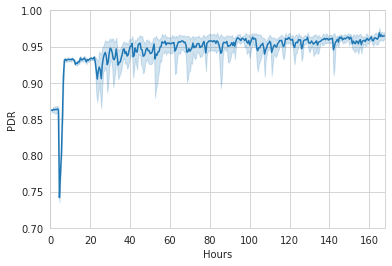

In [59]:
fileformat = 'pdf'
plots_dir = 'congestion-plots'
filename = '95pdr'

sns.lineplot(data=results,
             x='Hours', 
             y='PDR')
plt.ylim([0.7, 1])
plt.xlim([0, 168])
plt.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat))
plt.show()

## SF PDR over time

In [78]:
@sem.utils.output_labels(['Hours', 'PDR'])
def get_sf_pdr (result):
    """
    Extract the packet delivery ratio from nodeData.txt
    """
    lines = result['output']['nodeData.txt'].splitlines()
    
    pdr = []
    time = [0.5]
    sent = np.zeros (6)
    received = np.zeros (6)
    for l in lines[2000:]:
        line = l.split()
        t = float(line[0])/(60*60)
        if (t > time[-1]):
            pdr.append(received/sent)
            time.append(t)
            sent = np.zeros (6)
            received = np.zeros (6)
        sent[int(line[4])] += float(line[6])
        received[int(line[4])] += float(line[7])
    pdr.append(received/sent)
    return [time,pdr]

In [93]:
results = campaign.get_results_as_dataframe(get_sf_pdr,
                                            params=params)
results = results.explode(['Hours','PDR'],ignore_index=True)
results = results.explode('PDR', ignore_index=True)
results['datarate'] = [0,1,2,3,4,5] * 2174
results['SF'] = [12,11,10,9,8,7] * 2174
results

,devices,rings,periods,initSF,congest,file,debug,range,sir,adr,RngRun,Hours,PDR,datarate,SF
0,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,0.5,0.652273,0,12
1,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,0.5,0.852641,1,11
2,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,0.5,0.937423,2,10
3,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,0.5,0.959283,3,9
4,2000,1,168,True,True,True,False,2540.25,CROCE,False,5,0.5,0.973415,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13039,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,49.0,0.965517,1,11
13040,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,49.0,0.916667,2,10
13041,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,49.0,0.954315,3,9
13042,2000,1,168,True,True,True,False,2540.25,CROCE,False,0,49.0,0.964029,4,8


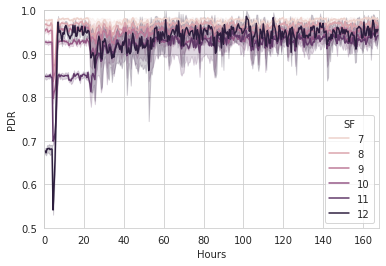

In [95]:
fileformat = 'pdf'
plots_dir = 'congestion-plots'
filename = '95pdrSF'

sns.lineplot(data=results,
             x='Hours', 
             y='PDR',
             hue='SF')
plt.ylim([0.5, 1])
plt.xlim([0, 168])
plt.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat))
plt.show()